In [1]:
library(ggplot2)
library(mgcv)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


# C3M4 Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Observe the difference between GAMs and other regression models on simulated data.
2. Review how to plot and interpret the coefficient linearity for GAM models.

General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [15]:
# Load packages
library(ggplot2)
library(mgcv)
library(magrittr)
library(gridExtra)

# Problem 1: GAMs with Simulated Data

In this example, we show how to check the validity of a generalized additive model (GAM) (using the `gam()` function) using simulated data. This allows us to try and understand the intricacies of `gam()` without having to worry about the context of the data. 

### 1. (a) Simulate the Data

Let $n = 200$. First, construct three predictor variables. The goal here is to construct a GAM with different types of predictor terms (e.g., factors, continuous variables, some that will enter linearly/parametrically, some that enter transformed).

1. x1: A continuous predictor that, we will suppose has a non-linear relationship with the response.
2. x2: A categorical variable with three levels: `s`, `m`, and `t`.
3. x3: A categorical variable with two levels: `TRUE` and `FALSE`.

Then, make the response some non-linear/non-parametric function of $\mathbf{x}$. For our case, use: $$\log(\mu_i) = \beta_1 + \sin(0.5x_{i,1}^2) - x_{i,2} + x_{i,3}$$ This model is a Poisson GAM. In a real-world situation, we wouldn't know this functional relationship and would estimate it. Other terms are modeled parametrically. The response has normal noise.

Note that:

1. The construction of $\boldsymbol\mu = (\mu_1,...,\mu_n)^T$ has the linear predictor exponentiated, because of the nature of the link function. 
2. We use $\boldsymbol\mu$ to construct $\mathbf{y}  = (y_1,...,y_n)^T $. The assumption for Poisson regression is that the random variable $Y_i$ that generates $y_i$ is Poisson with mean $\mu_i$. 
3. `as.integer(as.factor(VARIABLE))` converts the labels of VARIABLE to 1, 2, 3,.. so that we can construct the relationship for these factors.

Plot the relationship of $\mathbf{y}$ to each of the predictors. **Then, split the data into a training (`train_sim`) and test (`test_sim`) set**.

In [459]:
set.seed(0112358)
n <- 200
# construct the predictors
df <- data.frame(
    x1 = rnorm(n, mean = 45, sd = 15),
    x2 = sample(c('s', 'm', 't'), size = n, replace = TRUE),
    x3 = sample(c(TRUE, FALSE), size = n, replace = TRUE),
    stringsAsFactors = FALSE
)
# construct the response
df$mu <- with(df, exp(log(0.5*x1^2) - as.integer(as.factor(x2)) + as.integer(as.factor(x3))))
df$y <- rpois(n, df$mu)

summary(df)
head(df)

       x1             x2                x3                mu          
 Min.   :12.40   Length:200         Mode :logical   Min.   :   10.94  
 1st Qu.:33.54   Class :character   FALSE:105       1st Qu.:  207.56  
 Median :44.31   Mode  :character   TRUE :95        Median :  548.58  
 Mean   :44.98                                      Mean   : 1114.88  
 3rd Qu.:56.01                                      3rd Qu.: 1528.03  
 Max.   :90.61                                      Max.   :10458.72  
       y          
 Min.   :   10.0  
 1st Qu.:  204.5  
 Median :  557.5  
 Mean   : 1111.2  
 3rd Qu.: 1490.5  
 Max.   :10644.0  

,x1,x2,x3,mu,y
,<dbl>,<chr>,<lgl>,<dbl>,<int>
1,37.93226,t,FALSE,97.36401,87
2,62.19000,m,FALSE,1933.79786,1955
3,52.95074,s,FALSE,515.72659,493
4,39.17245,s,FALSE,282.25199,262
5,63.85257,m,TRUE,5541.42216,5487
6,17.41148,t,FALSE,20.51411,13


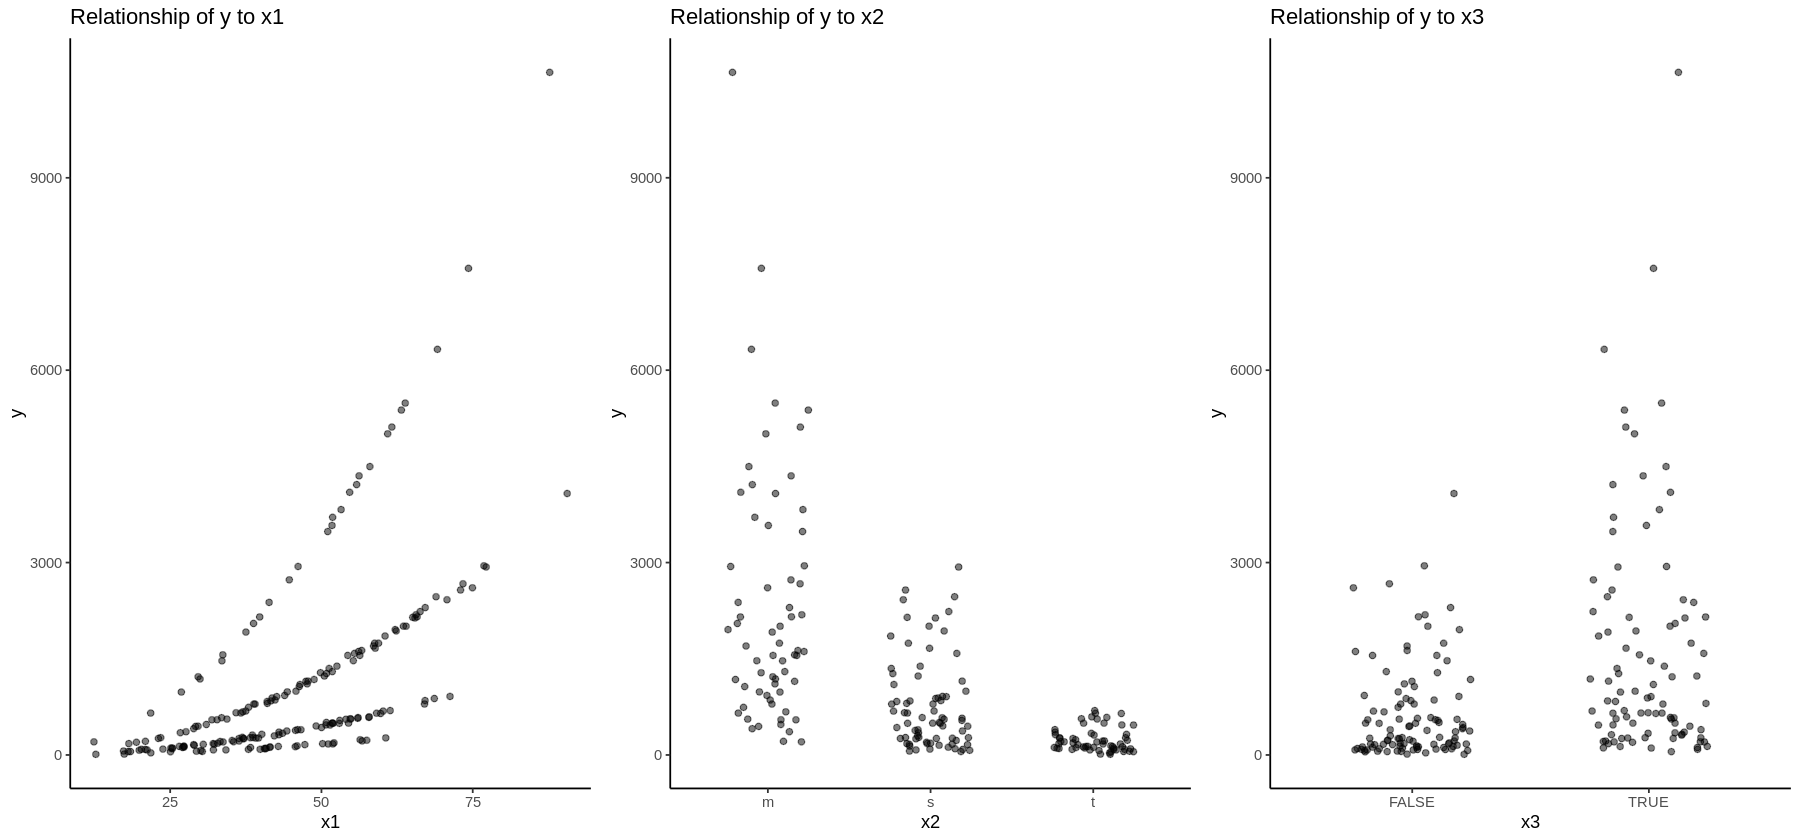

In [460]:
# plot the relationship between y and each of the predictors
p1 <- df %>% 
    ggplot(aes(x = x1, y = y)) +
    geom_point(alpha = 0.5) +
    ggtitle("Relationship of y to x1") +
    theme_classic()

p2 <- df %>% 
    ggplot(aes(x = x2, y = y)) +
    geom_jitter(alpha = 0.5, width = 0.25) +
    ggtitle("Relationship of y to x2") +
    theme_classic()

p3 <- df %>% 
    ggplot(aes(x = x3, y = y)) +
    geom_jitter(alpha = 0.5, width = 0.25) +
    ggtitle("Relationship of y to x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, p3, ncol = 3)

`geom_smooth()` using method = 'loess'

`geom_smooth()` using method = 'loess'



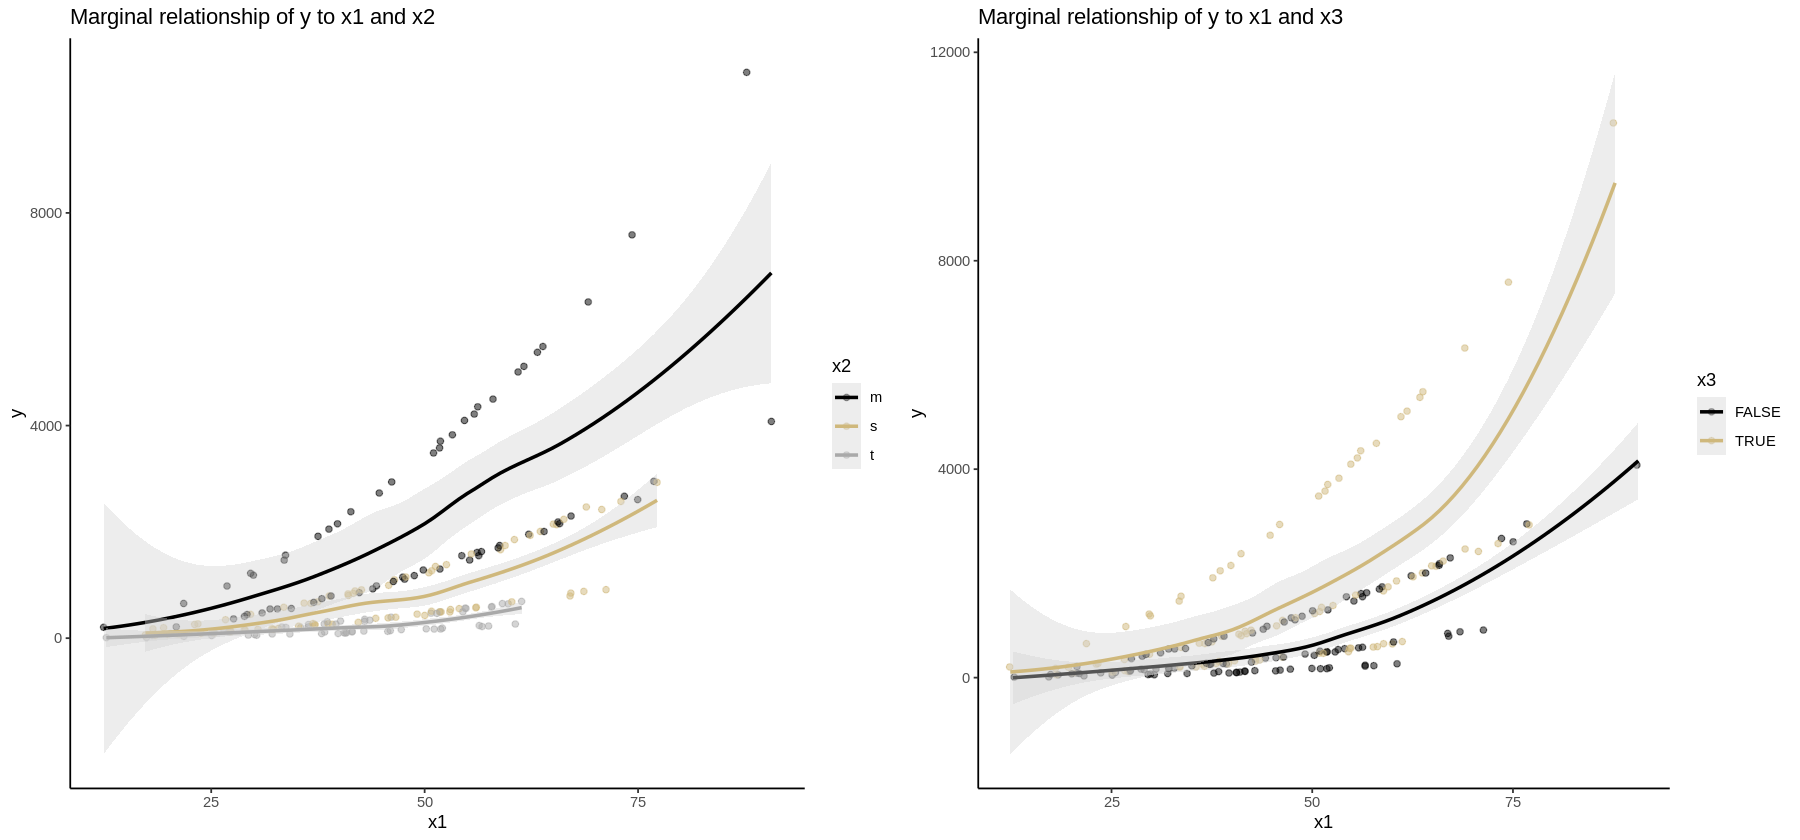

In [461]:
# also plot the marginal relationships
p1 <- df %>% 
    ggplot(aes(x = x1, y = y, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_smooth(formula = y ~ x, fill = "lightgrey") +
    scale_colour_manual(values = c('black','#CFB87C', 'darkgrey')) +
    ggtitle("Marginal relationship of y to x1 and x2") +
    theme_classic()

p2 <- df %>% 
    ggplot(aes(x = x1, y = y, col = x3)) +
    geom_jitter(alpha = 0.5, width = 0.25) +
    geom_smooth(formula = y ~ x, fill = "lightgrey") +
    scale_colour_manual(values = c('black','#CFB87C')) +
    ggtitle("Marginal relationship of y to x1 and x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

In [462]:
# split the data into a training and test set
num_rows <- nrow(df)
m <- floor(0.8 * num_rows)
idx <- sample(seq_len(num_rows), size = m)

train_sim <- df[idx, ]
test_sim <- df[-idx, ]

### 1. (b) Other Regression Models

Before jumping straight into GAMs, let's test if other regression models work. What about a regular linear regression model with ordinary least squares, and a generalized linear model for Poisson regression?

First fit a linear regression model to your `train_sim` data. We know that all of the predictors were used to make the response, but are they all significant in the linear regression model? Explain why this may be.

Then fit a Generalize Linear Model (GLM) to the `train_sim` data. Plot three diagnostic plots for your GLM:

1. Residual vs. log(Fitted Values)
2. QQPlot of the Residuals
3. Actual Values vs. Fitted Values

Using these plots, determine whether this model is a good fit for the data. Make sure to explain your conclusions and reasoning.

In [463]:
# Fit a LM model to the data
lm_mod <- lm(y ~ x1 + x2 + x3, data = train_sim)
summary(lm_mod)


Call:
lm(formula = y ~ x1 + x2 + x3, data = train_sim)

Residuals:
    Min      1Q  Median      3Q     Max 
-1023.3  -499.0  -218.0   358.9  5765.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -602.301    249.115  -2.418   0.0168 *  
x1             50.592      4.442  11.390  < 2e-16 ***
x2s         -1382.092    158.251  -8.734 3.73e-15 ***
x2t         -1829.944    169.237 -10.813  < 2e-16 ***
x3TRUE       1043.294    132.402   7.880 5.40e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 832.1 on 155 degrees of freedom
Multiple R-squared:  0.7098,	Adjusted R-squared:  0.7023 
F-statistic: 94.79 on 4 and 155 DF,  p-value: < 2.2e-16


All the predictors including $x_1$ are statistically significant and the $R^2$ values are reasonable, indicating that we shouldn't always trust model diagnostics. The diagnostic plots thankfully indicate that the model fit is poor.

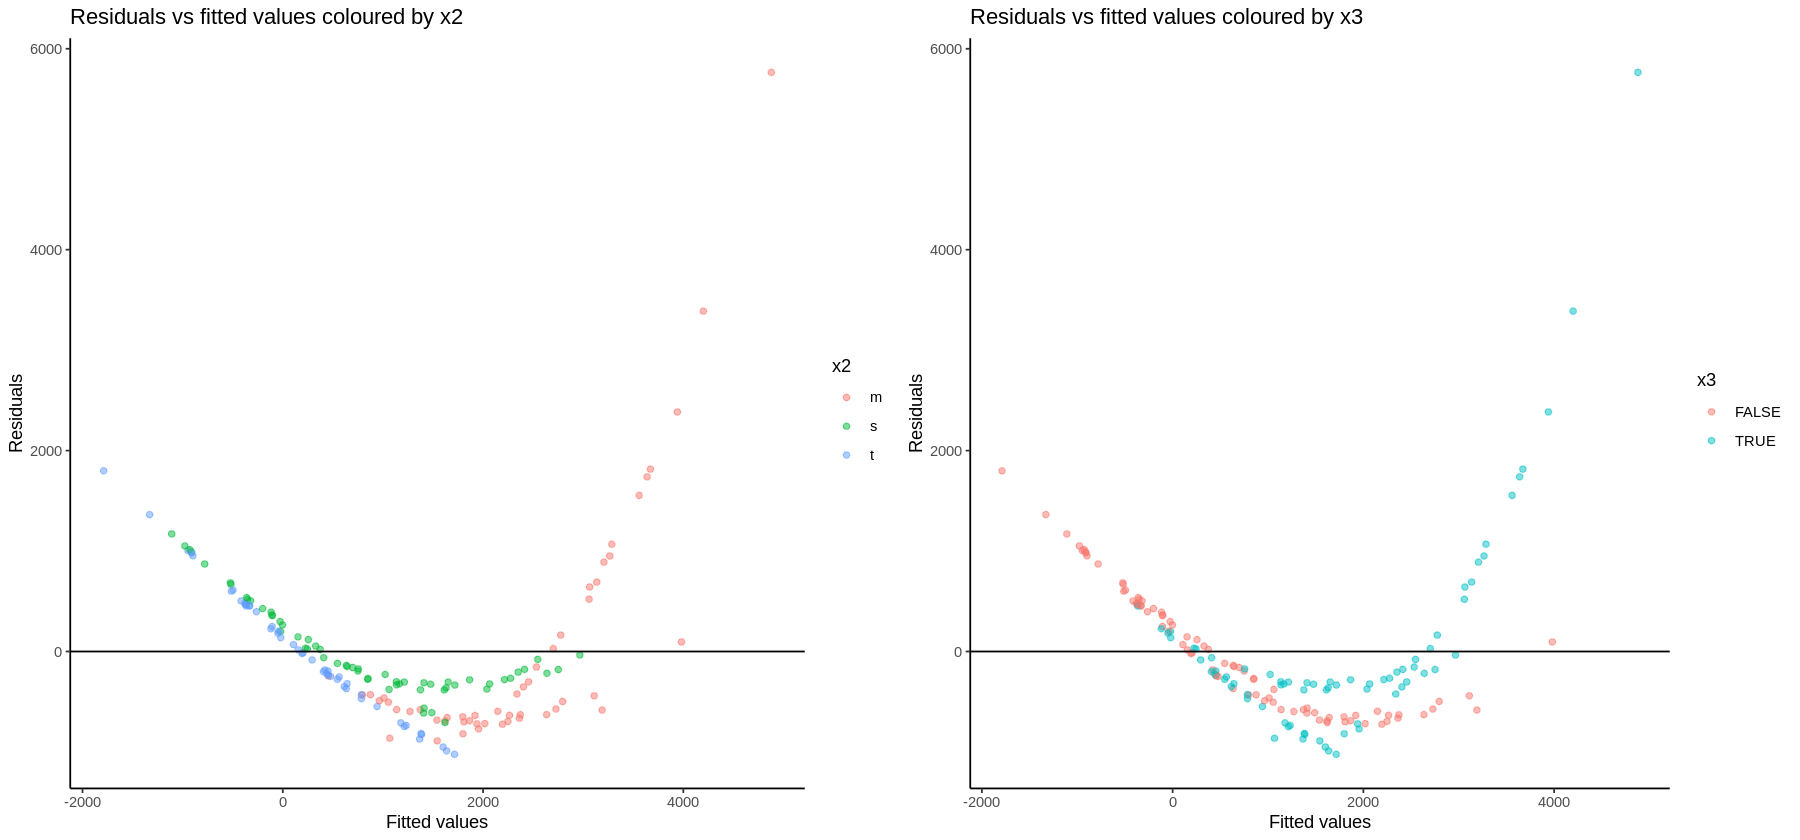

In [477]:
# residual plot
mod_df <- data.frame(preds = predict(lm_mod, type = "response"),
                     res = residuals(lm_mod),
                     x2 = train_sim$x2,
                     x3 = train_sim$x3,
                     y = train_sim$y)

p1 <- mod_df %>% 
    ggplot(aes(x = preds, y = res, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values coloured by x2") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(x = preds, y = res, col = x3)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values coloured by x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

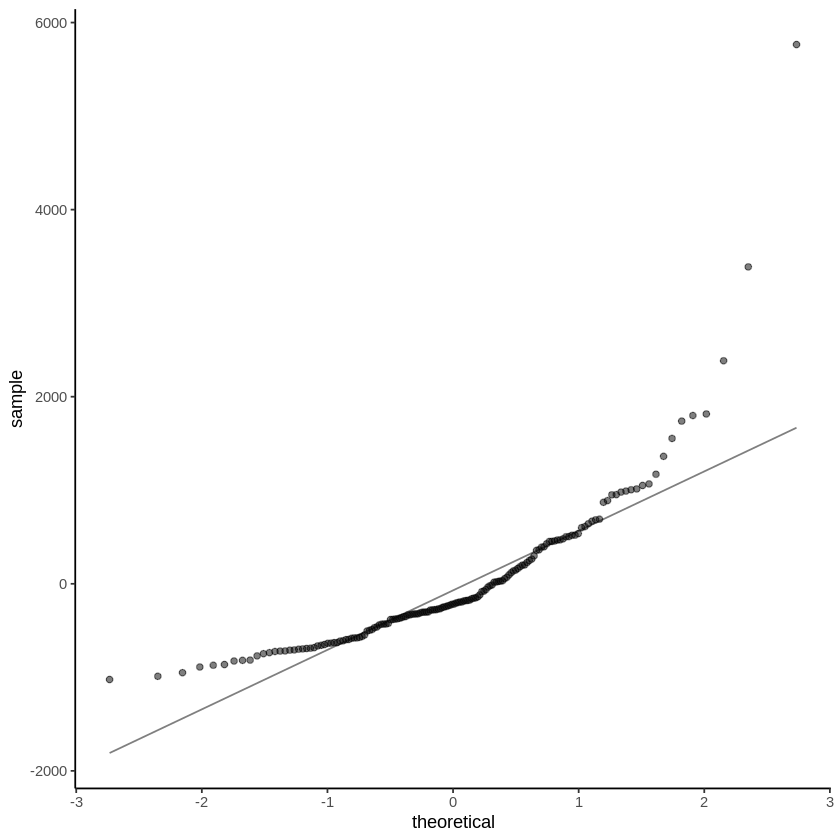

In [478]:
# qq plot
options(repr.plot.width = NULL, repr.plot.height = NULL)
mod_df %>% 
    ggplot(aes(sample = res)) +
    stat_qq(alpha = 0.5) +
    stat_qq_line(alpha = 0.5) +
    theme_classic()

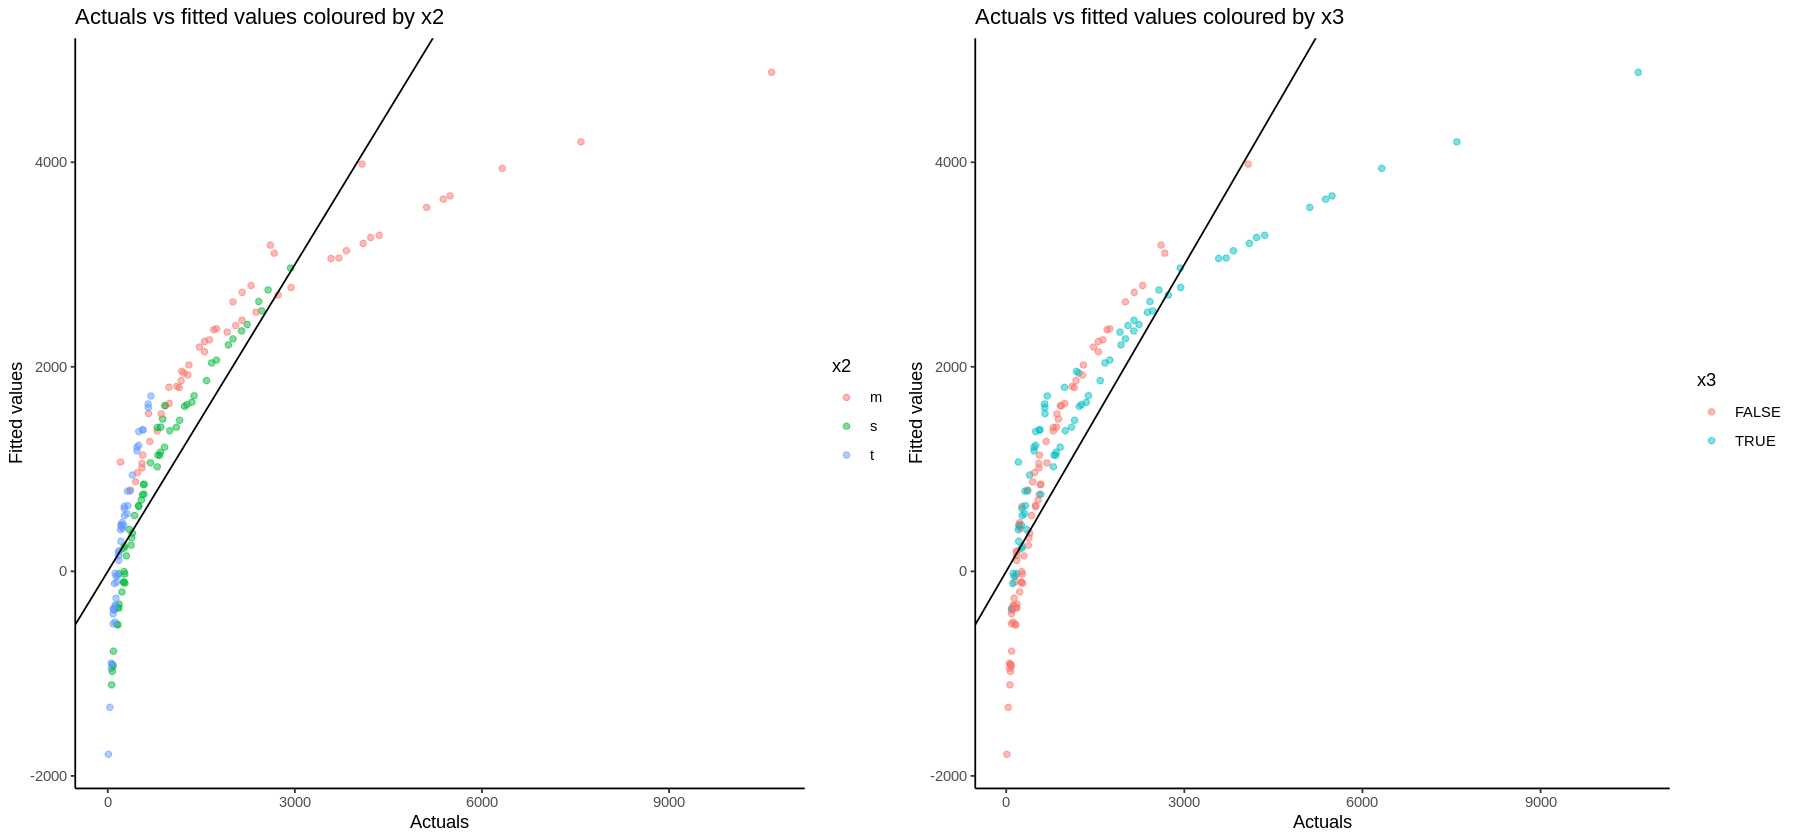

In [479]:
p1 <- mod_df %>% 
    ggplot(aes(x = y, y = preds, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values coloured by x2") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(x = y, y = preds, col = x3)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values coloured by x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

In [480]:
# Fit a GLM model to the data
glm_mod <- glm(y ~ x1 + x2 + x3, data = train_sim, family = poisson)
summary(glm_mod)


Call:
glm(formula = y ~ x1 + x2 + x3, family = poisson, data = train_sim)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-23.7475   -1.8468    0.7573    2.1219    7.1528  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.1531375  0.0096271   535.3   <2e-16 ***
x1           0.0374916  0.0001446   259.3   <2e-16 ***
x2s         -0.9788115  0.0053526  -182.9   <2e-16 ***
x2t         -1.9655685  0.0098283  -200.0   <2e-16 ***
x3TRUE       1.0073512  0.0051424   195.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 224723.5  on 159  degrees of freedom
Residual deviance:   3166.6  on 155  degrees of freedom
AIC: 4483.4

Number of Fisher Scoring iterations: 4


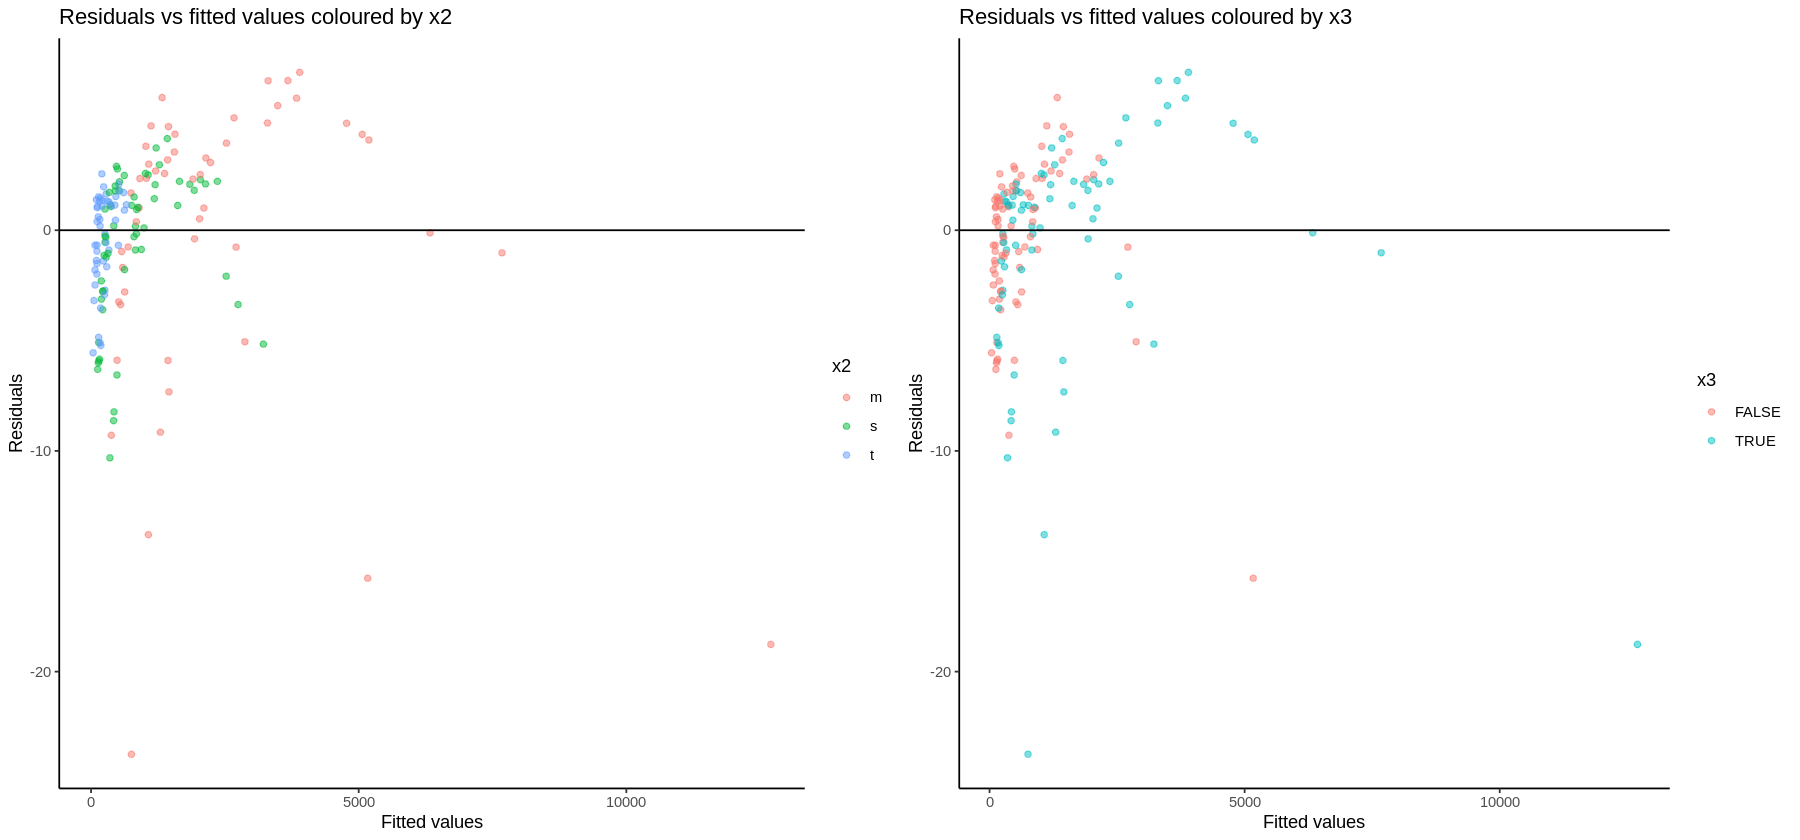

In [481]:
# residual plot
mod_df <- data.frame(preds = predict(glm_mod, type = "response"),
                     res = residuals(glm_mod, type = "deviance"),
                     x2 = train_sim$x2,
                     x3 = train_sim$x3,
                     y = train_sim$y)

p1 <- mod_df %>% 
    ggplot(aes(x = preds, y = res, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values coloured by x2") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(x = preds, y = res, col = x3)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values coloured by x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

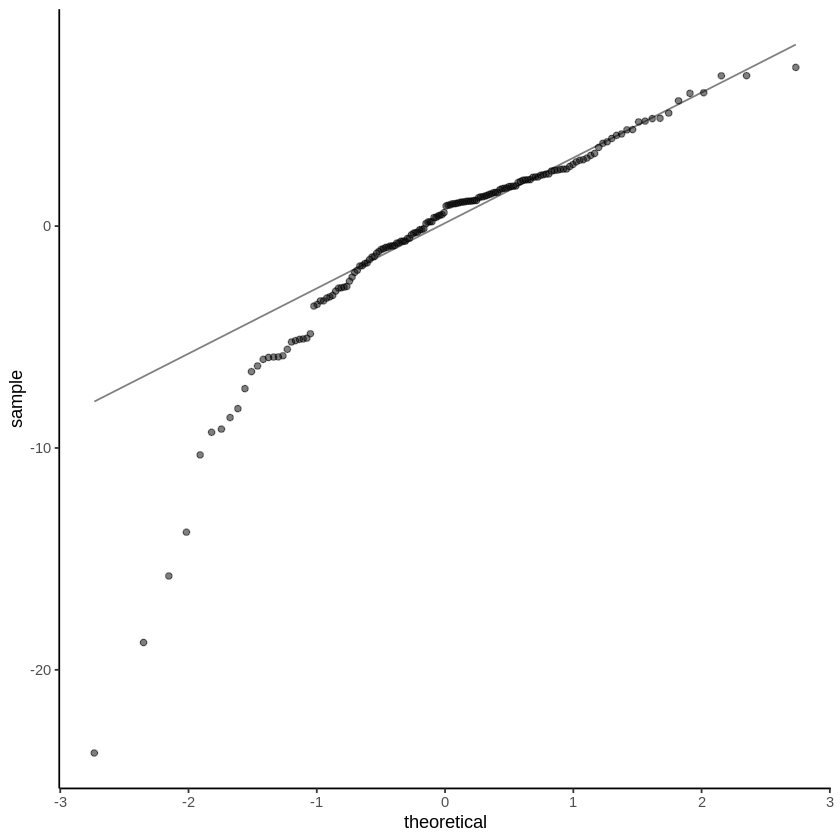

In [482]:
# qq plot
options(repr.plot.width = NULL, repr.plot.height = NULL)
mod_df %>% 
    ggplot(aes(sample = res)) +
    stat_qq(alpha = 0.5) +
    stat_qq_line(alpha = 0.5) +
    theme_classic()

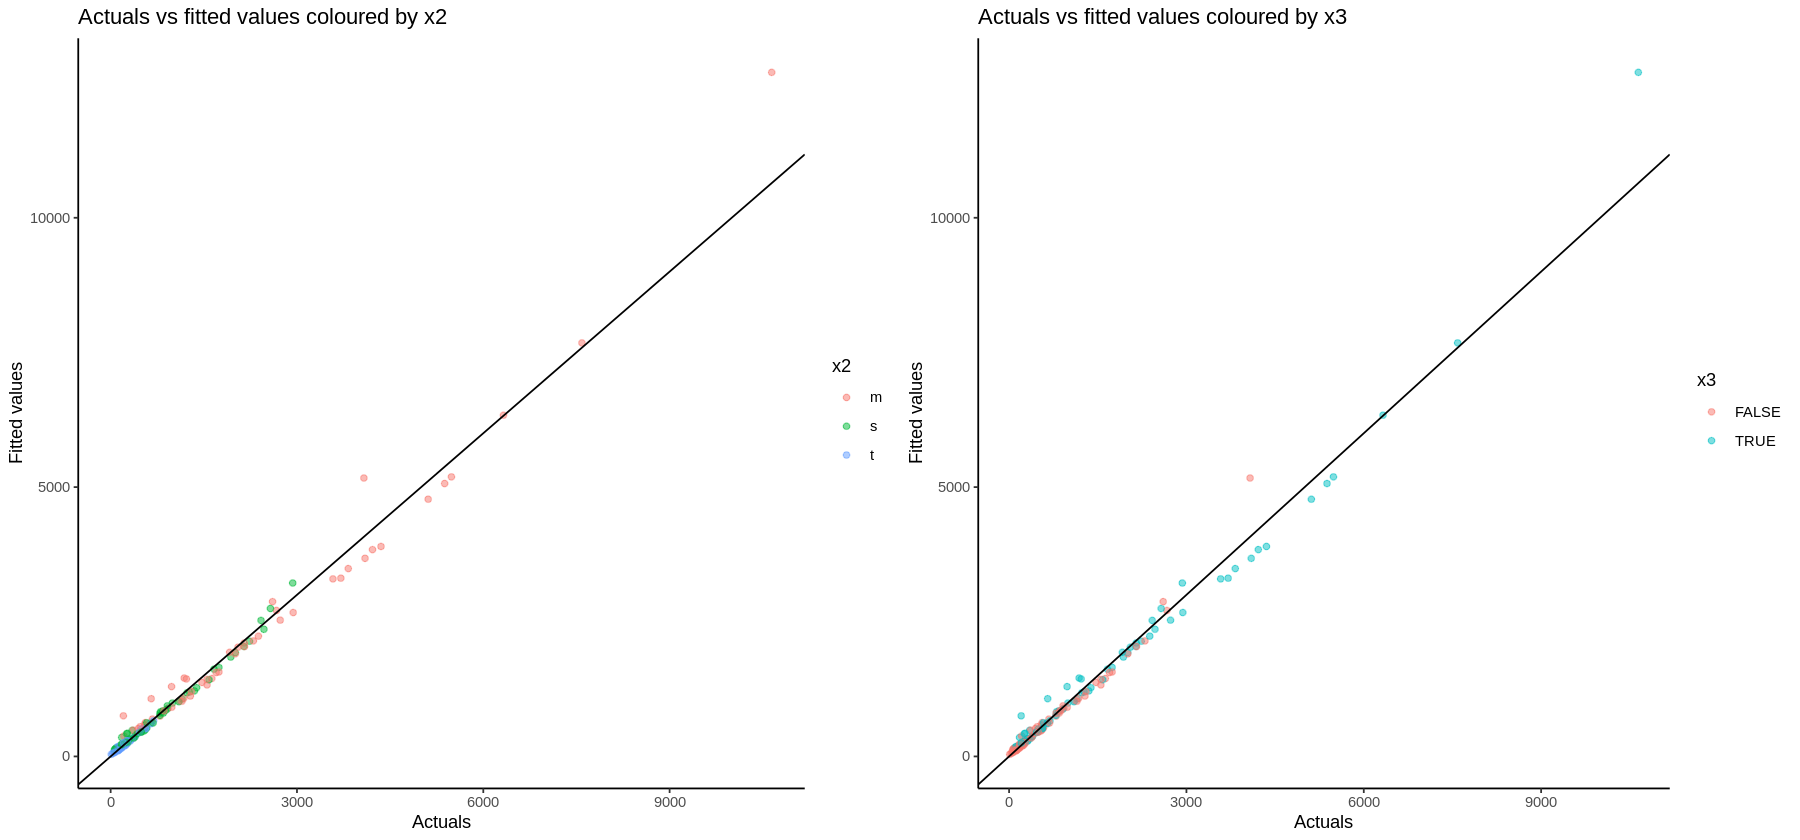

In [483]:
# fitted vs actuals plot
p1 <- mod_df %>% 
    ggplot(aes(x = y, y = preds, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values coloured by x2") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(x = y, y = preds, col = x3)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values coloured by x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

There is lots of evidence that the glm model is a poor fit:

1. The coefficient on $x_1$ is statistically significant.
2. The residual vs fitted plot does not show a random scatter of points.
3. The qq plot shows clear deviations from normality at the lower end, which is due to an incorrect model functional form.

### 1. (c) Looking for those GAMs

Now, it's time to see how a generalized additive model (GAM) performs! Fit a GAM to the data. Construct the same three plots for your GAM model. Do these plots look better than those of the GLM?

In [484]:
# Fit a GAM model to the data
gam_mod <- gam(y ~ s(x1) + x2 + x3, data = train_sim, family = poisson)
summary(gam_mod)


Family: poisson 
Link function: log 

Formula:
y ~ s(x1) + x2 + x3

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.835544   0.005122  1334.6   <2e-16 ***
x2s         -1.001787   0.005487  -182.6   <2e-16 ***
x2t         -2.002740   0.009876  -202.8   <2e-16 ***
x3TRUE       1.006298   0.005176   194.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df Chi.sq p-value    
s(x1) 8.615  8.945  57951  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.999   Deviance explained = 99.9%
UBRE = 0.11782  Scale est. = 1         n = 160

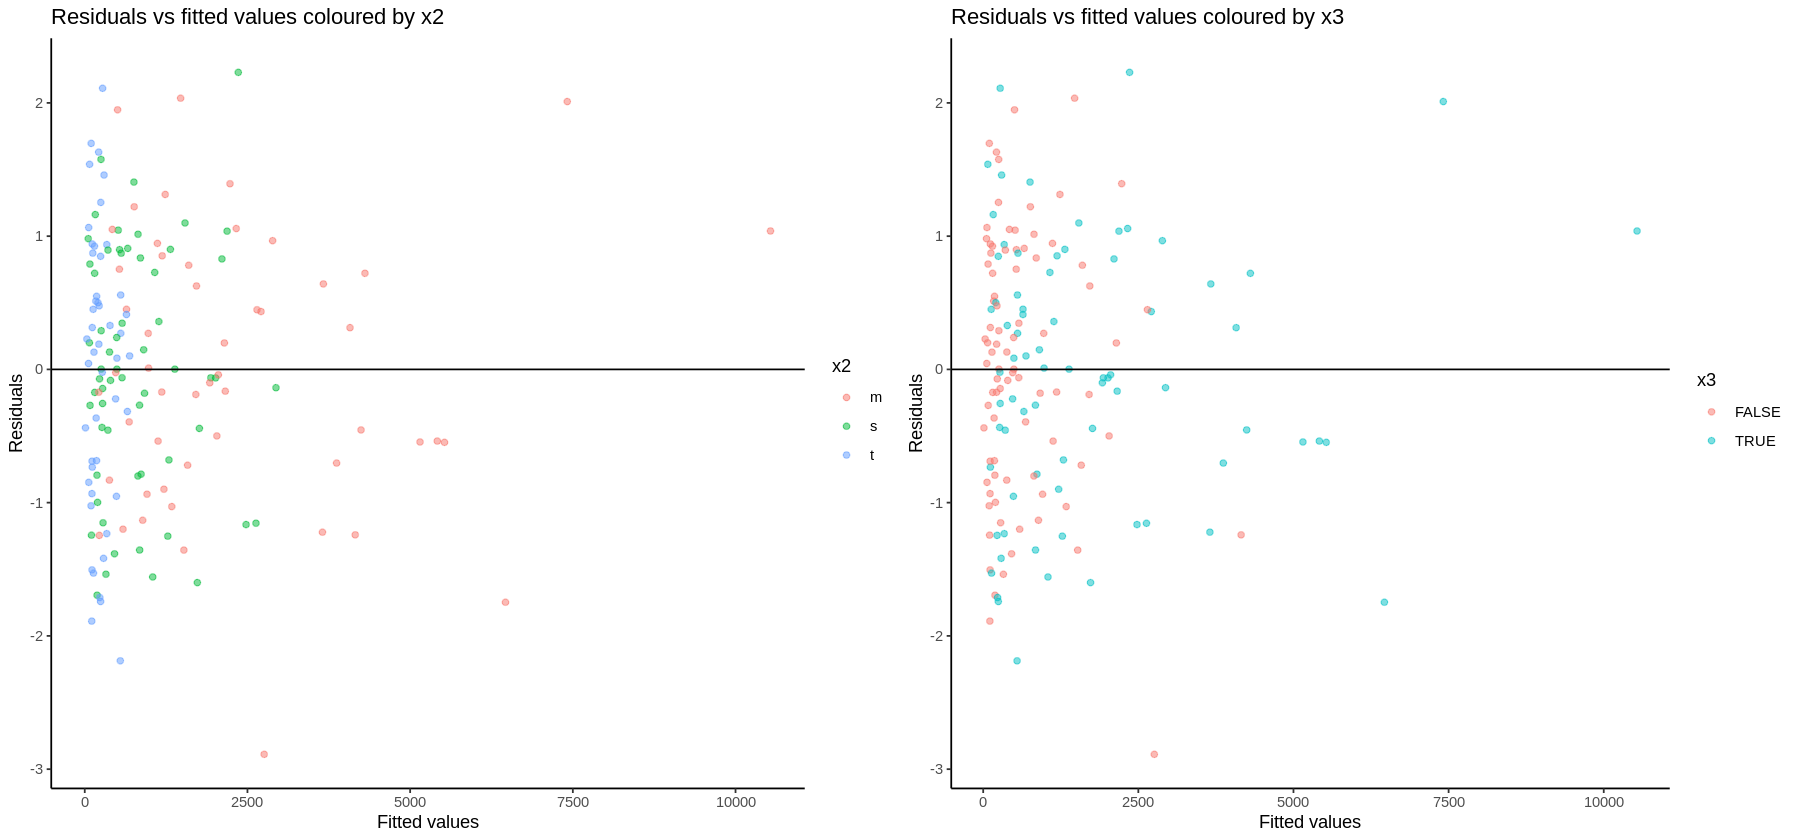

In [485]:
# residual plot
mod_df <- data.frame(preds = predict(gam_mod, type = "response"),
                     res = residuals(gam_mod, type = "deviance"),
                     x2 = train_sim$x2,
                     x3 = train_sim$x3,
                     y = train_sim$y)

p1 <- mod_df %>% 
    ggplot(aes(x = preds, y = res, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values coloured by x2") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(x = preds, y = res, col = x3)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values coloured by x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

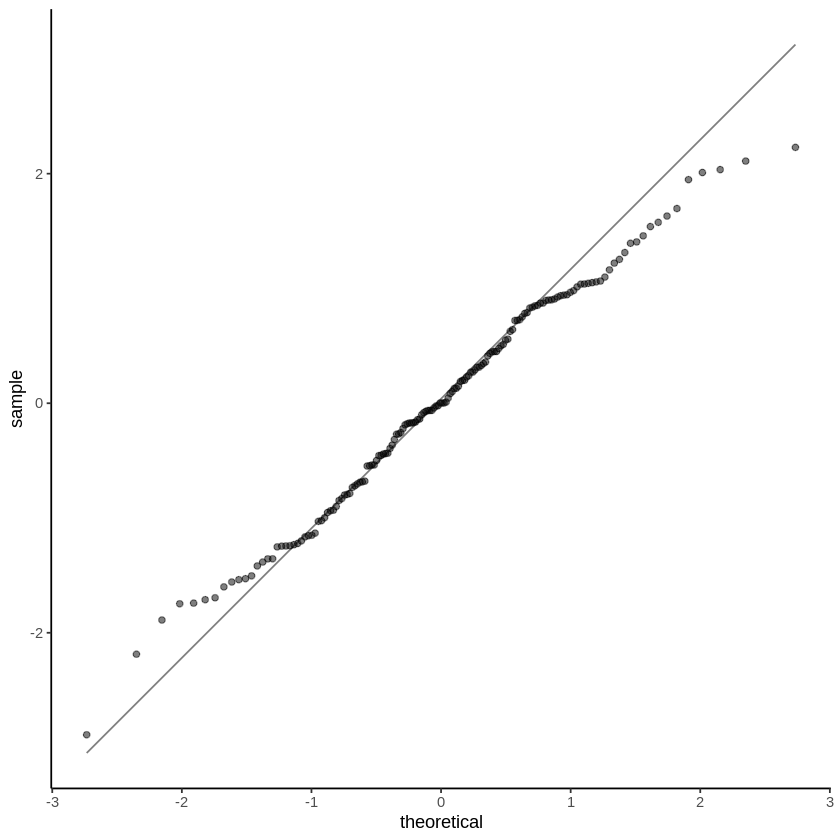

In [486]:
# qq plot
options(repr.plot.width = NULL, repr.plot.height = NULL)
mod_df %>% 
    ggplot(aes(sample = res)) +
    stat_qq(alpha = 0.5) +
    stat_qq_line(alpha = 0.5) +
    theme_classic()

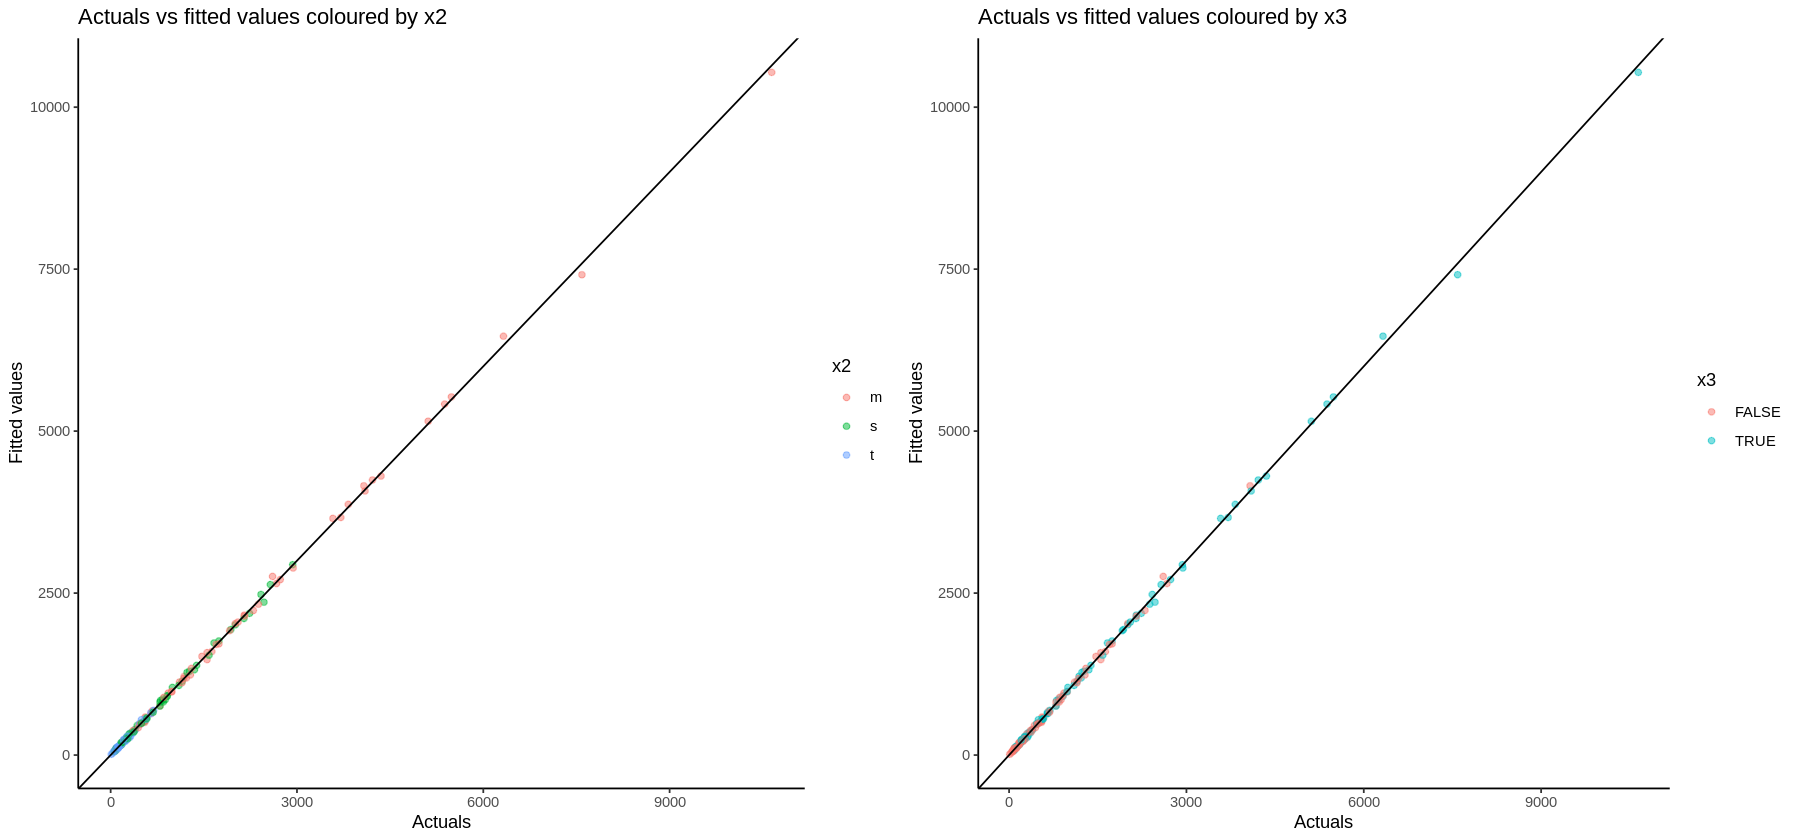

In [487]:
# fitted vs actuals plot
p1 <- mod_df %>% 
    ggplot(aes(x = y, y = preds, col = x2)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values coloured by x2") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(x = y, y = preds, col = x3)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values coloured by x3") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, ncol = 2)

All plots look much better:

1. There is a random scatter of points in both residual plots.
2. Only minor deviations in the tails of the qqplot.
3. A close fit to the $y = x$ line in the fitted vs actuals plot.

### 1. (d) Interpreting GAMs

We made a GAM model! However GAMs are harder to interpret than regular linear regression models. How do we determine if a GAM model was necesary? Or, in other words, how do we determine if our predictors have a linear relationship with the response?

Use the `plot.gam()` function in the mgcv library to plot the relationship between `y` and `x1`. Recall that $x_1$ entered our model as $\sin(0.5x_{i,1}^2)$, and we plotted that relationship in **1.(a)**. Does your plot confirm this relationship?

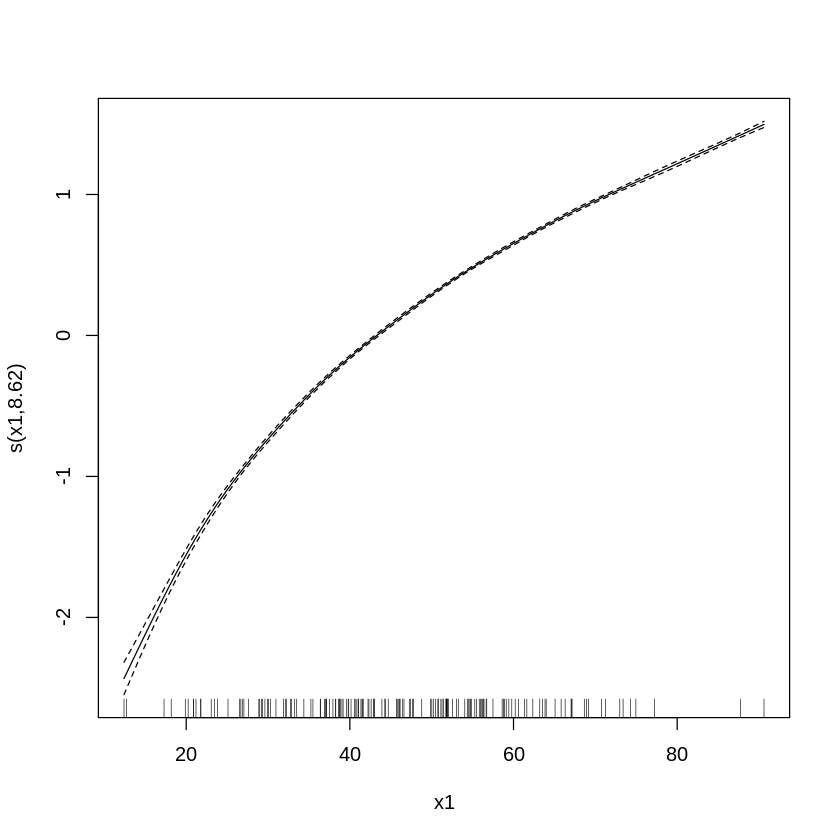

In [489]:
options(repr.plot.width = NULL, repr.plot.height = NULL)
plot.gam(gam_mod)

The visualisation of the non-linear parameter confirms the known relationship. We see that the relationship between the response and $x_1$ is stronger for lower values of $x_1$ and becomes weaker as $x_1$ gets larger.

### 1.(e) Model comparison

Compute the mean squared prediction error (MSPE) for each of the three models above (regression model, GLM, and GAM). State which model performs based according to this metric.

Remember, the MSPE is given by 

\begin{align*}
MSPE = \frac{1}{k}\sum^k_{i=1}\left(y^\star_i - \widehat{y}^\star_i \right)^2 
\end{align*}

where $y^\star_i$ are the observed response values in the test set and $\widehat{y}^\star_i$ are the predicted values for the test set (using the model fit on the training set).

In [490]:
# mspe for lm
preds <- predict(lm_mod, newdata = test_sim)
lm_mspe <- mean((test_sim$y - preds)^2)
lm_mspe

# mspe for glm
preds <- predict(glm_mod, newdata = test_sim)
glm_mspe <- mean((test_sim$y - preds)^2)
glm_mspe

# mspe for gam
preds <- predict(gam_mod, newdata = test_sim)
gam_mspe <- mean((test_sim$y - preds)^2)
gam_mspe

[1] 453282.4

[1] 2382107

[1] 2382064

Unsurprisingly, the best performing model in this case was the generalised additive model.

# Problem 2 Additive models with the advertising data

The following dataset containts measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`: the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook`: the advertising budget allocated to Facebook. Measured in thousands of dollars; and 

- `newspaper`: the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`: the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

First, we load the data, plot it, and split it into a training set (`train_marketing`) and a test set (`test_marketing`).

,youtube,facebook,newspaper,sales
,<dbl>,<dbl>,<dbl>,<dbl>
1,276.12,45.36,83.04,26.52
2,53.40,47.16,54.12,12.48
3,20.64,55.08,83.16,11.16
4,181.80,49.56,70.20,22.20
5,216.96,12.96,70.08,15.48
6,10.44,58.68,90.00,8.64


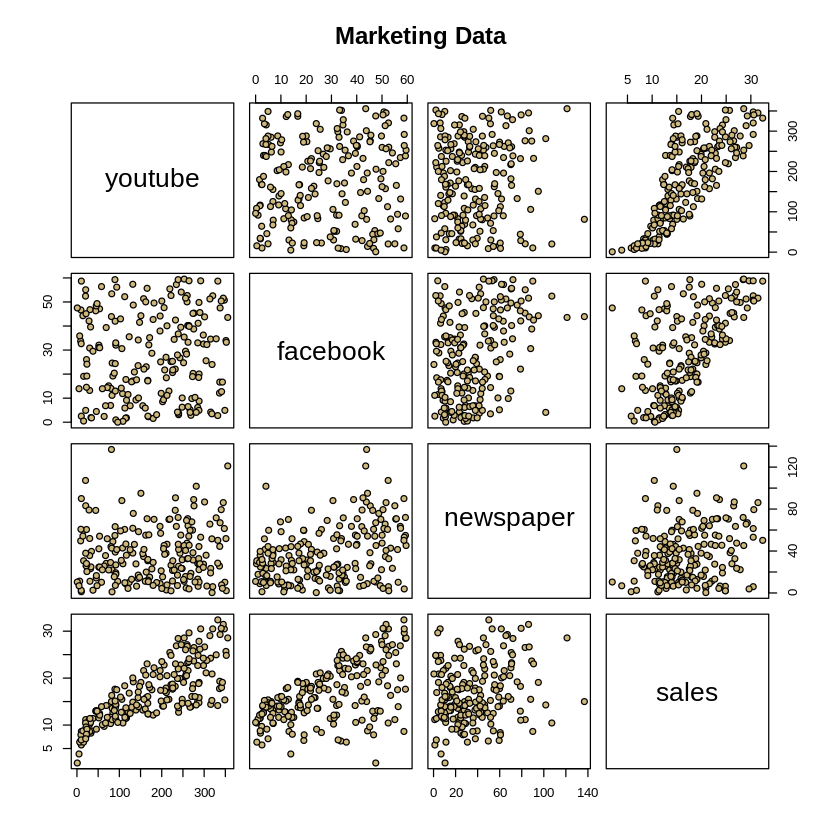

In [296]:
# Load in the data
marketing = read.csv("marketing.txt", sep = "")
head(marketing)

pairs(marketing, main = "Marketing Data", pch = 21, bg = c("#CFB87C"))

In [297]:
set.seed(177)
n = floor(0.8 * nrow(marketing))
index = sample(seq_len(nrow(marketing)), size = n)

train_marketing = marketing[index, ]
test_marketing = marketing[-index, ]

dim(test_marketing)
dim(train_marketing)

[1] 40  4

[1] 160   4

**2.(a) Let's try a GAM on the marketing data!**

Note that the relationship between `sales` and `youtube` is nonlinear. This was a problem for us back in the first course in this specialization, when we modeled the data as if it were linear. In the last module, we focused on modeling the relationship between `sales` and `youtube`, omitting the other variables. Now it's time to include the additional predictors.

Using the `train_marketing` fit an additive model to the data and store it in `gam_marketing`. Produce the relevant added variable plots using `plot(gam_marketing)`. Comment on the fit of the model.

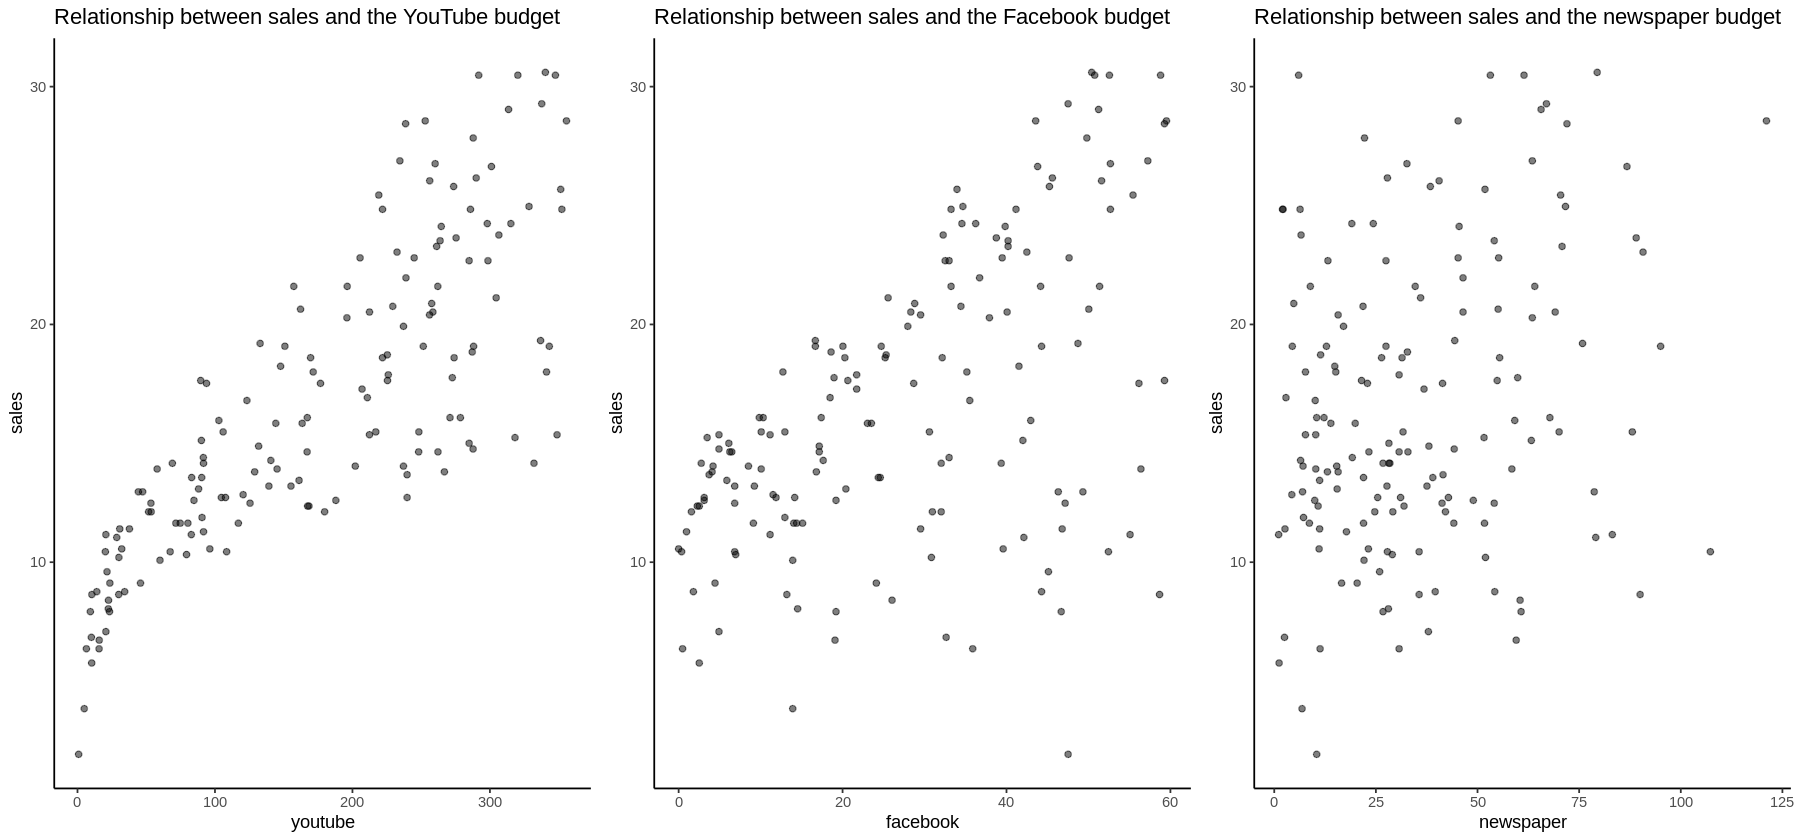

In [318]:
p1 <- train_marketing %>% 
    ggplot(aes(x = youtube, y = sales)) +
    geom_point(alpha = 0.5) +
    ggtitle("Relationship between sales and the YouTube budget") +
    theme_classic()

p2 <- train_marketing %>% 
    ggplot(aes(x = facebook, y = sales)) +
    geom_point(alpha = 0.5) +
    ggtitle("Relationship between sales and the Facebook budget") +
    theme_classic()

p3 <- train_marketing %>% 
    ggplot(aes(x = newspaper, y = sales)) +
    geom_point(alpha = 0.5) +
    ggtitle("Relationship between sales and the newspaper budget") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, p3, ncol = 3)

In [326]:
gam_marketing <- gam(sales ~ s(youtube) + facebook + newspaper, data = train_marketing)
summary(gam_marketing)


Family: gaussian 
Link function: identity 

Formula:
sales ~ s(youtube) + facebook + newspaper

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.264013   0.279555  40.293   <2e-16 ***
facebook     0.186582   0.008530  21.874   <2e-16 ***
newspaper    0.004403   0.005811   0.758     0.45    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
           edf Ref.df     F p-value    
s(youtube) 5.9  7.047 202.1  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.929   Deviance explained = 93.2%
GCV = 2.9718  Scale est. = 2.8065    n = 160

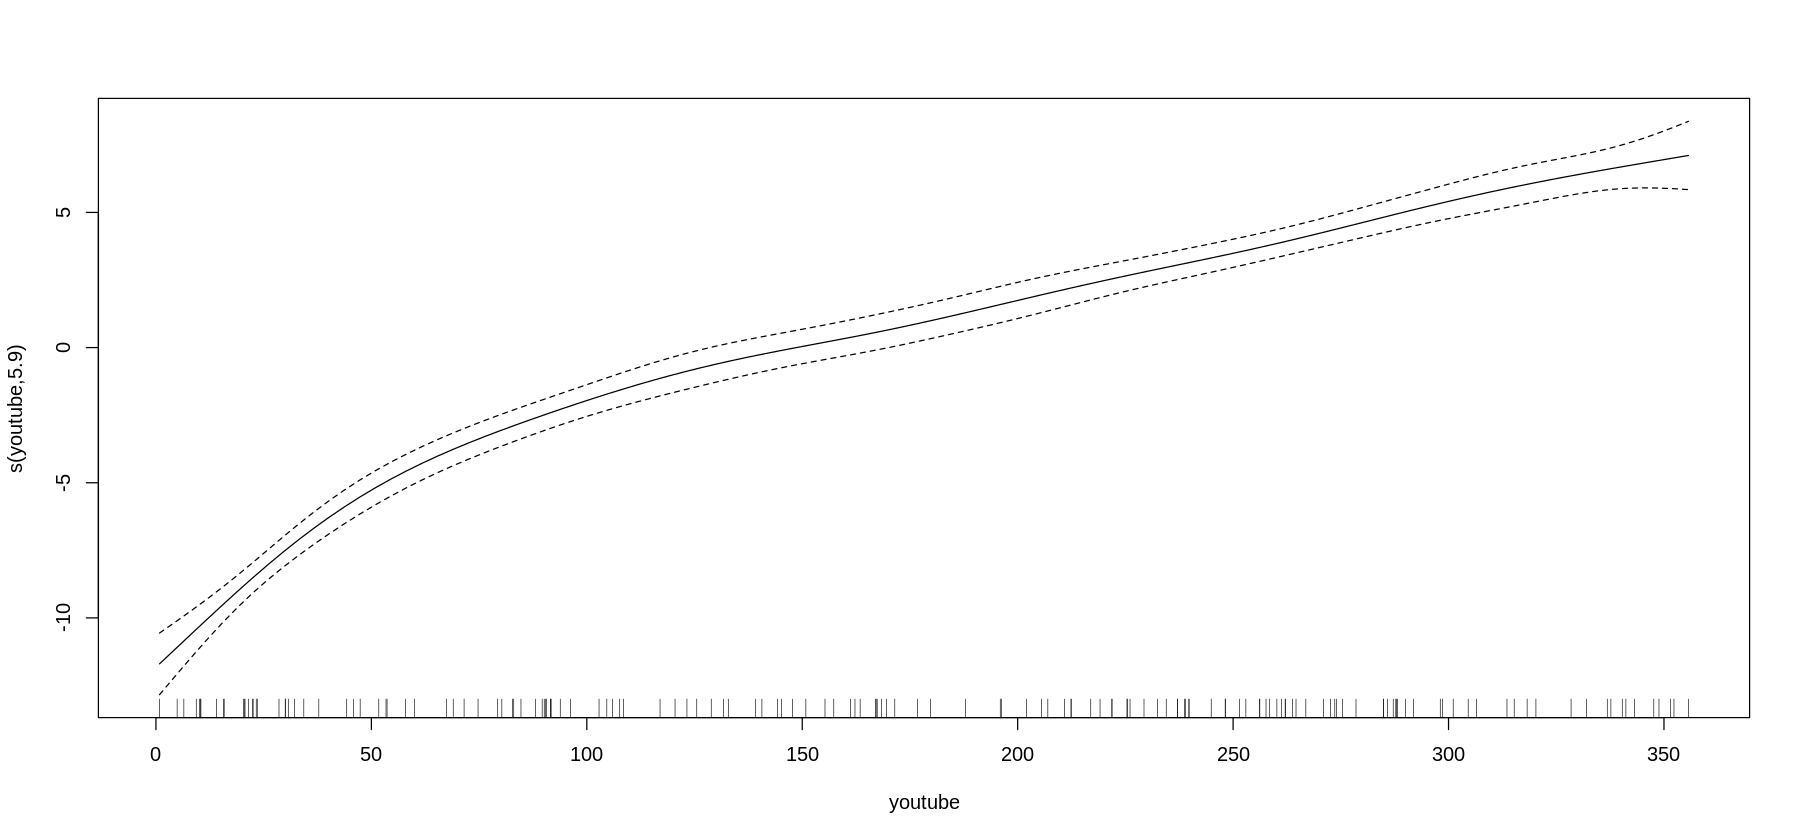

In [327]:
plot.gam(gam_marketing)

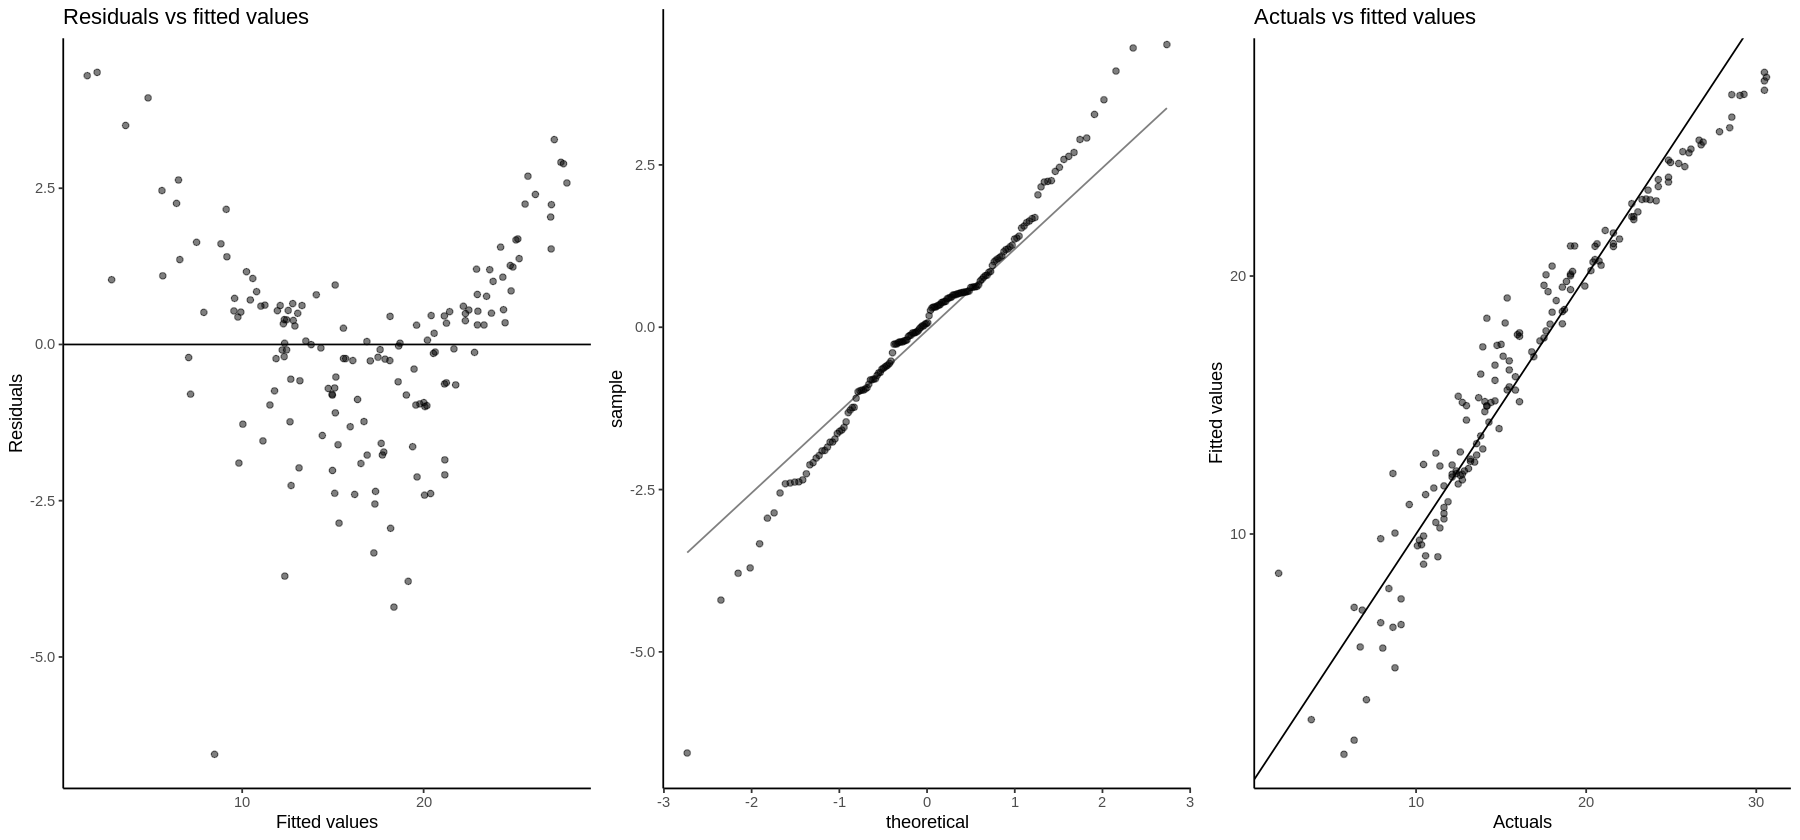

In [330]:
# residual plot
mod_df <- data.frame(preds = predict(gam_marketing),
                     res = residuals(gam_marketing),
                     actuals = train_marketing$sales)

p1 <- mod_df %>% 
    ggplot(aes(x = preds, y = res)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(sample = res)) +
    stat_qq(alpha = 0.5) +
    stat_qq_line(alpha = 0.5) +
    theme_classic()

p3 <- mod_df %>% 
    ggplot(aes(x = actuals, y = preds)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values") +
    theme_classic()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, p3, ncol = 3)

The model fit is reasonably good, but there are some indications that it may be problematic at the edges:

- the $R^2$ and adjusted $R^2$ values are both very high (over 90%), suggesting a good fit
- the fitted vs actuals points are reasonably close to the $y = x$ line, but deviate at the upper and lower margins
- the coefficient for `newspaper` is statistically insignificant
- there is a definite shape to the residuals
- the qqplot shows reasonable deviation at the upper and lower ends.

(Note that an additional iteration indicated that both `facebook` and `newspaper` should enter the model parametrically.)

**2.(b) Semiparametric modeling of the marketing data**

Refit the additive model based on your results from 2.(a). That is, if any predictors above should enter linearly, refit the model to reflect that. If any predictors are statistically insignificant, remove them from the model. Store your final model in `semiparametric_marketing`.

In [331]:
semiparametric_marketing <- gam(sales ~ s(youtube) + facebook, data = train_marketing)
summary(semiparametric_marketing)


Family: gaussian 
Link function: identity 

Formula:
sales ~ s(youtube) + facebook

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.352099   0.253895   44.71   <2e-16 ***
facebook     0.189085   0.007848   24.09   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df     F p-value    
s(youtube) 5.979  7.127 200.9  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.929   Deviance explained = 93.2%
GCV = 2.9438  Scale est. = 2.797     n = 160

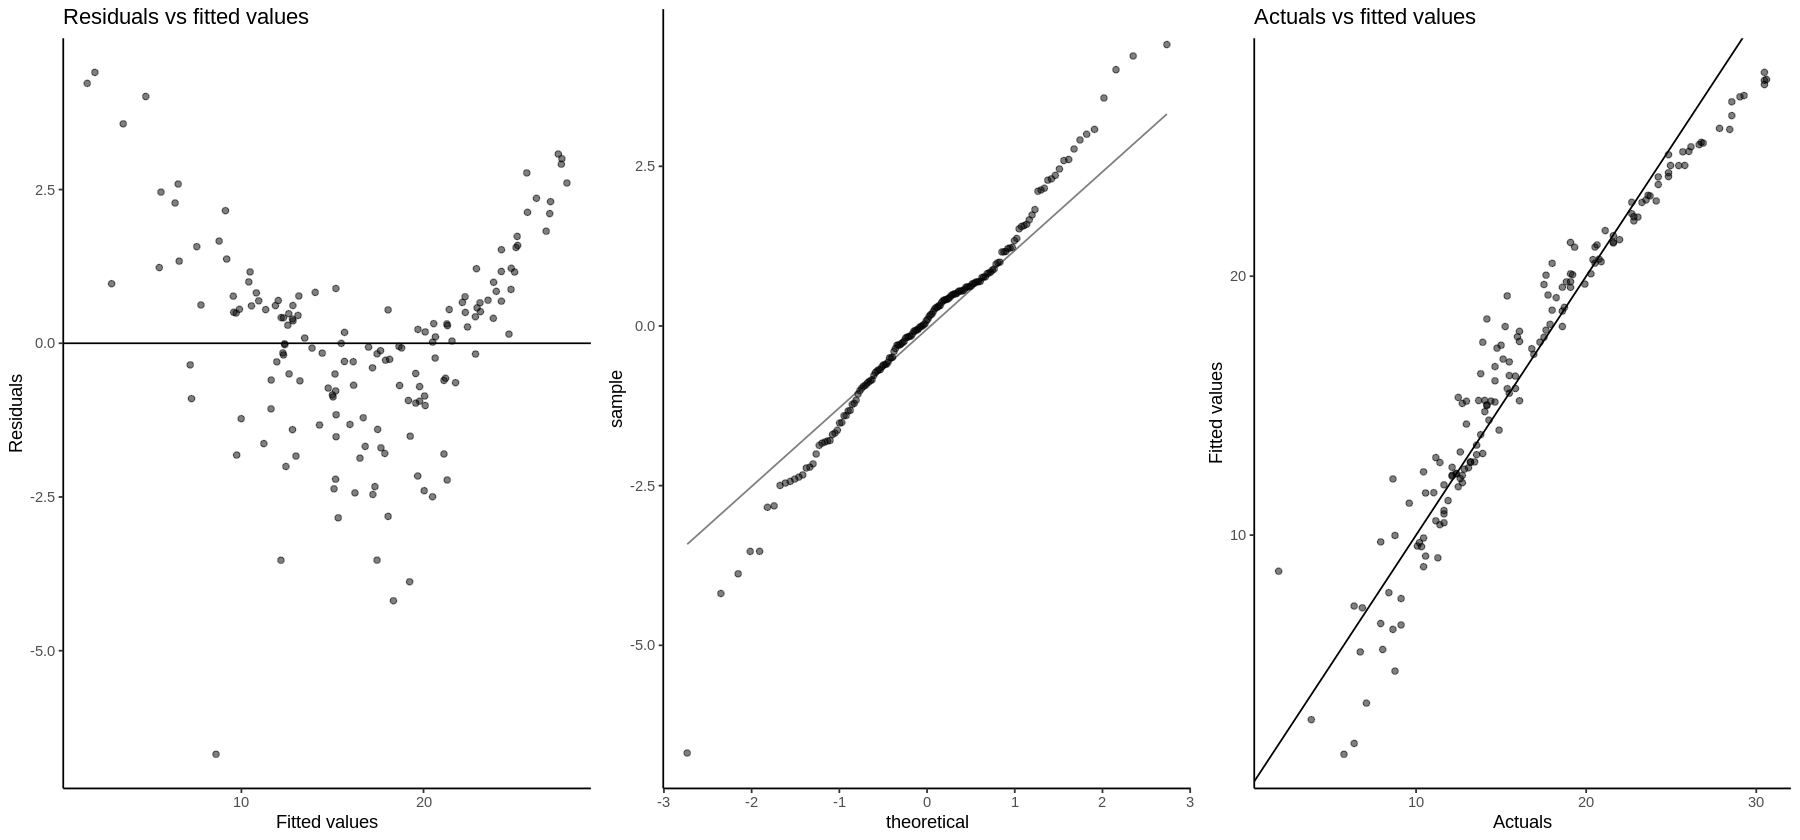

In [333]:
# residual plot
mod_df <- data.frame(preds = predict(semiparametric_marketing),
                     res = residuals(semiparametric_marketing),
                     actuals = train_marketing$sales)

p1 <- mod_df %>% 
    ggplot(aes(x = preds, y = res)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0) +
    labs(x = "Fitted values", y = "Residuals", title = "Residuals vs fitted values") +
    theme_classic()

p2 <- mod_df %>% 
    ggplot(aes(sample = res)) +
    stat_qq(alpha = 0.5) +
    stat_qq_line(alpha = 0.5) +
    theme_classic()

p3 <- mod_df %>% 
    ggplot(aes(x = actuals, y = preds)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1) +
    labs(x = "Actuals", y = "Fitted values", title = "Actuals vs fitted values") +
    theme_classic()

grid.arrange(p1, p2, p3, ncol = 3)

**2.(c) Model comparisons**

Now, let's do some model comparisons on the test data. Compute the mean squared prediction error (MSPE) on the `test_marketing` data for the following three models:

- `gam_marketing` from 2.(a)


- `semiparametric_marketing`from 2.(b)


- `lm_marketing`, a linear regression model with `sales` is the response and `youtube` and `facebook` are predictors (fit on the `train_marketing` data).

State which model performs based according to this metric.

In [336]:
# mspe for gam
preds <- predict(gam_marketing, newdata = test_marketing)
gam_mspe <- mean((test_marketing$sales - preds)^2)
gam_mspe

# mspe for semi-parametric
preds <- predict(semiparametric_marketing, newdata = test_marketing)
gam2_mspe <- mean((test_marketing$sales - preds)^2)
gam2_mspe

# mspe for lm
lm_marketing <- lm(sales ~ ., data = train_marketing)
preds <- predict(lm_marketing, newdata = test_marketing)
lm_mspe <- mean((test_marketing$sales - preds)^2)
lm_mspe

[1] 3.409949

[1] 3.297448

[1] 4.248602

The best model in this situation was the semi-parametric model i.e the model with `newspaper` removed as a predictor.